# Box plots for all results tables (In experiments)

In [1]:
import os
import numpy as np
import pprint
from fastestimator.summary.logs import parse_log_file
import matplotlib.pyplot as plt

/home/yunchan/anaconda3/envs/tf2.3/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
def plot_appendix(task, ylim=None): 
    if task == "image_classification":
        lr_list = ["0.01", "0.001", "0.0001"]
        merge_lr = "0.01"
        metric = "accuracy"
        func = np.max
        task_brief = "IC"
    elif task == "instance_detection":
        lr_list = ["0.01", "0.005", "0.001"]
        merge_lr = "0.001"
        metric = "mAP"
        func = np.max
        task_brief = "ID"
    elif task == "language_modeling":
        lr_list = ["1.0", "0.1", "0.01"]
        merge_lr = "1.0"
        metric = "perplexity"
        func = np.min
        task_brief = "IM"
    else:
        raise ValueError("not known task")
        
    result = {}
    for init_lr in lr_list:
        result[init_lr] = []
        if init_lr == "1.0":
            init_lr_fix = "1"
        else:
            init_lr_fix = init_lr.replace(".", "")
            
        # normal 
        for scheduler in ["base-lr",
                          "cosine-decay",
                          "cyclic-cosine-decay",
                          "exponential-decay"]:
            stat = []
            for run in range(5):
                summary = parse_log_file(f"../../../logs/normal_comparison/{task}/{init_lr_fix}_{scheduler}_{run}.txt", ".txt")
                best = func([x for x in summary.history["eval"][metric].values()])
                stat.append(best)
            result[init_lr].append(stat)
        
        # meta comparison
        if init_lr == merge_lr:
            # meta
            for scheduler in ["sls", "superconvergence"]:
                stat = []
                for run in range(5):
                    summary = parse_log_file(f"../../../logs/meta_comparison/{task}/{scheduler}_{run}.txt", ".txt")
                    best = func([x for x in summary.history["eval"][metric].values()])
                    stat.append(best)
                result[init_lr].append(stat)

        # ARC 
        for scheduler in ["lr-controller-weighted-acc"]:
            stat = []
            for run in range(5):
                summary = parse_log_file(f"../../../logs/normal_comparison/{task}/{init_lr_fix}_{scheduler}_{run}.txt", ".txt")
                best = func([x for x in summary.history["eval"][metric].values()])
                stat.append(best)
            result[init_lr].append(stat)
        
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    
    for i, key in enumerate(result.keys()):
        bplot1 = axs[i].boxplot(
            result[key],
            vert=True,  # vertical box aligmnent
            patch_artist=True)  # fill with color

        # set ax title
        axs[i].set_title(f"init_lr = {key}")

        # adding horizontal grid lines
        axs[i].yaxis.grid(True)
        if key == merge_lr:
            axs[i].set_xticks([y+1 for y in range(7)])
            axs[i].set_xticklabels(["BLR", "CD", "CCD", "ED", "SLS", "SC", "ARC"])
        else:
            axs[i].set_xticks([y+1 for y in range(5)])
            axs[i].set_xticklabels(["BLR", "CD", "CCD", "ED", "ARC"])
            
    plt.savefig(f"../../../results/supplementary/appendix_{task_brief}.jpeg", dpi=300, transparent=True)

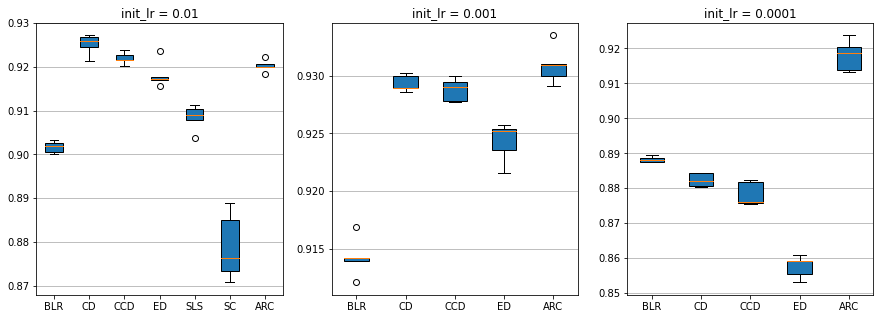

In [3]:
plot_appendix("image_classification")

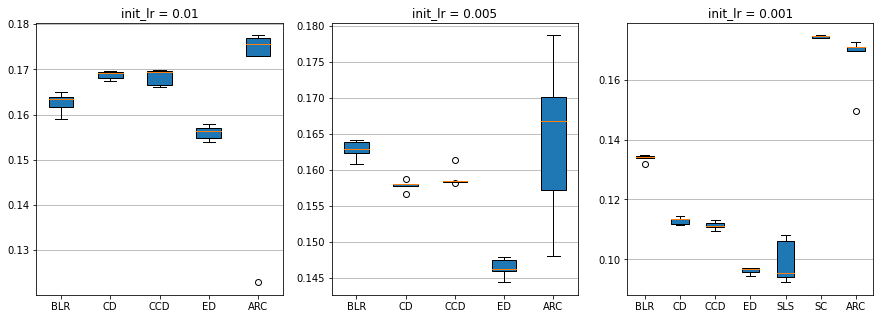

In [4]:
plot_appendix("instance_detection")

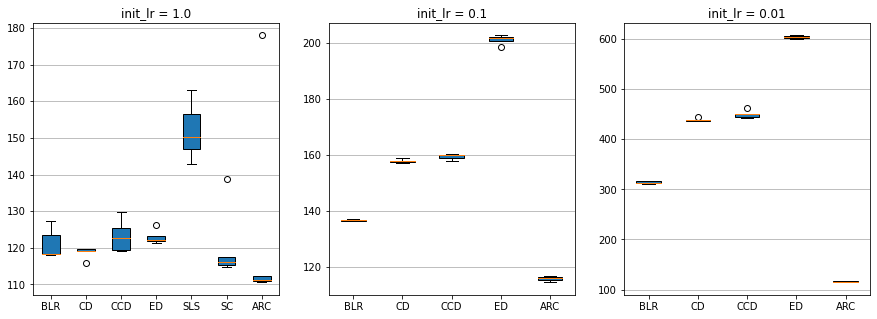

In [5]:
plot_appendix("language_modeling")